### 📘 Final Term Project
Does the Energy Transition Pay Off? Evidence on Renewable Adoption and CO₂ Emissions Across Countries
<br> *by Farangiz Jurakhonova*

---

### Introduction

Climate change and rising carbon emissions represent one of the most pressing global challenges for policymakers, businesses, and energy companies. In response, many countries have committed to an energy transition that shifts energy production and consumption away from fossil fuels toward renewable energy sources. Renewable energy is often presented as a central instrument for reducing greenhouse gas emissions and achieving long-term sustainability goals.

Despite the widespread policy emphasis on renewable energy, an important empirical question remains: does a higher share of renewable energy consumption actually translate into lower carbon emissions? Countries differ substantially in their level of economic development, population size, and energy demand, all of which may influence emissions independently of energy mix. As a result, the effectiveness of renewable energy adoption cannot be assessed without accounting for these structural differences.

This project investigates whether renewable energy adoption is associated with lower CO₂ emissions per capita across countries. Using cross-sectional data from the World Bank, the analysis examines the relationship between renewable energy share and emissions while controlling for income level and population size. The aim is to assess whether the energy transition “pays off” in terms of reduced emissions and to discuss the extent to which the observed relationships can support policy and business insights.

---


### Data

Data
The final dataset consists of 268 countries observed in 2019. After removing observations with missing values, the analysis is based on a cross-sectional sample of 245 observations. The dataset includes greenhouse gas emissions per capita (CO₂-equivalent, excluding LULUCF) as the outcome variable, renewable energy consumption as a share of total final energy use as the main explanatory variable, and GDP per capita and population size as control variables.

The large cross-country coverage improves the external validity of the results, although heterogeneity across countries may still limit causal interpretation.

---

### Research question:
Is renewable energy adoption associated with lower greenhouse gas emissions per capita across countries, controlling for income level and population size?

---

### Model
3.1 Model specification

To examine the relationship between renewable energy adoption and carbon emissions, this project estimates a linear regression model using cross-sectional data. The logarithm of CO₂ emissions per capita is used as the dependent variable to account for the skewed distribution of emissions and to allow for percentage-based interpretation of the coefficients.

The baseline model relates log CO₂ emissions per capita to the share of renewable energy consumption, while controlling for economic development and population size. GDP per capita and population are also transformed using logarithms to reduce skewness and improve interpretability.

In [49]:
#Load libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [50]:
## Load World Bank energy and emissions data for 2019 directly from GitHub: data was downloaded from WBD and later will be shaped/cleaned for analysis
energy_df = (pd.read_csv(
    "https://raw.githubusercontent.com/FarangizJ/da2-energy-emissions-project/main/worldbank_energy_2019.csv"
)
)
energy_df.head()


,Country Name,Country Code,Series Name,Series Code,2019 [YR2019]
0,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,496.6025042585
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,37856121
2,Afghanistan,AFG,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,18.9
3,Afghanistan,AFG,Total greenhouse gas emissions excluding LULUC...,EN.GHG.ALL.PC.CE.AR5,0.712772447023825
4,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,5460.4305086932


In [51]:
energy_df.columns


Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2019 [YR2019]'],
      dtype='object')

### Data reshaping and variable construction
The original World Bank dataset is provided in long format, where each country appears multiple times for different indicators. To prepare the data for regression analysis, the dataset is reshaped into a wide, country-level format so that each row represents a single country.

Key indicators—GDP per capita, population size, renewable energy consumption, and greenhouse gas emissions per capita—are extracted and aligned by country. Variable names are simplified for clarity and consistency in the regression analysis.


In [52]:
# Rename the year column for easier handling
energy_df = energy_df.rename(columns={"2019 [YR2019]": "value"})


In [53]:
# Reshape data so each country is one observation with all indicators as columns
energy_wide = energy_df.pivot_table(
    index=["Country Name", "Country Code"],
    columns="Series Name",
    values="value",
    aggfunc="first"
).reset_index()



In [54]:
energy_wide.head()
energy_wide.columns


Index(['Country Name', 'Country Code', 'GDP per capita (current US$)',
       'Population, total',
       'Renewable energy consumption (% of total final energy consumption)',
       'Total greenhouse gas emissions excluding LULUCF per capita (t CO2e/capita)'],
      dtype='object', name='Series Name')

In [55]:
# Simplify variable names for regression analysis
energy_wide = energy_wide.rename(columns={
    "GDP per capita (current US$)": "gdp_pc",
    "Population, total": "population",
    "Renewable energy consumption (% of total final energy consumption)": "renewable_share",
    "Total greenhouse gas emissions excluding LULUCF per capita (t CO2e/capita)": "ghg_pc"
})

In [56]:
energy_wide.columns



Index(['Country Name', 'Country Code', 'gdp_pc', 'population',
       'renewable_share', 'ghg_pc'],
      dtype='object', name='Series Name')

In [57]:
energy_wide = energy_wide[
    [
        "Country Name",
        "Country Code",
        "gdp_pc",
        "population",
        "renewable_share",
        "ghg_pc"
    ]
]


In [58]:
energy_wide.isna().sum()


Series Name
Country Name       0
Country Code       0
gdp_pc             0
population         0
renewable_share    0
ghg_pc             0
dtype: int64

In [59]:
energy_wide

Series Name,Country Name,Country Code,gdp_pc,population,renewable_share,ghg_pc
0,Afghanistan,AFG,496.6025042585,37856121,18.9,0.712772447023825
1,Africa Eastern and Southern,AFE,1493.81793829992,675950189,62.6907096127666,2.21791502447448
2,Africa Western and Central,AFW,1798.34068458315,463365429,75.0787881678252,1.90894064304482
3,Albania,ALB,5460.4305086932,2854191,40.1,3.01962973045602
4,Algeria,DZA,4468.45341883656,43294546,0.2,5.87613044839412
...,...,...,...,...,...,...
261,West Bank and Gaza,PSE,3656.85827137011,4685306,13.9,..
262,World,WLD,11376.8233409998,7778303912,18.5751641385934,6.40541205652558
263,"Yemen, Rep.",YEM,..,35111408,3,0.957529245195749
264,Zambia,ZMB,1258.98619844462,18513839,86.1,1.44891613241316


In [60]:
energy_wide.dtypes



Series Name
Country Name       object
Country Code       object
gdp_pc             object
population         object
renewable_share    object
ghg_pc             object
dtype: object

In [61]:
cols_to_numeric = ["ghg_pc", "gdp_pc", "population", "renewable_share"]

for col in cols_to_numeric:
    energy_wide[col] = pd.to_numeric(energy_wide[col], errors="coerce")


In [62]:
energy_wide = energy_wide.dropna()
energy_wide.shape


(245, 6)

The dataset was checked for missing values and inconsistent data types before estimation. After cleaning, no missing observations remained in the variables used for regression.

In [63]:
energy_wide = energy_wide.copy()


In [64]:
# Log-transform variables to reduce skewness and allow elastic interpretation
energy_wide["ln_ghg_pc"] = np.log(energy_wide["ghg_pc"])
energy_wide["ln_gdp_pc"] = np.log(energy_wide["gdp_pc"])
energy_wide["ln_population"] = np.log(energy_wide["population"])


In [65]:
energy_wide

Series Name,Country Name,Country Code,gdp_pc,population,renewable_share,ghg_pc,ln_ghg_pc,ln_gdp_pc,ln_population
0,Afghanistan,AFG,496.602504,3.785612e+07,18.900000,0.712772,-0.338593,6.207790,17.449303
1,Africa Eastern and Southern,AFE,1493.817938,6.759502e+08,62.690710,2.217915,0.796568,7.309090,20.331630
2,Africa Western and Central,AFW,1798.340685,4.633654e+08,75.078788,1.908941,0.646548,7.494620,19.954027
3,Albania,ALB,5460.430509,2.854191e+06,40.100000,3.019630,1.105134,8.605283,14.864299
4,Algeria,DZA,4468.453419,4.329455e+07,0.200000,5.876130,1.770898,8.404798,17.583537
...,...,...,...,...,...,...,...,...,...
259,Viet Nam,VNM,3440.900254,9.717378e+07,20.400000,5.007709,1.610979,8.143488,18.392011
260,Virgin Islands (U.S.),VIR,38633.529892,1.066690e+05,6.200000,0.228745,-1.475147,10.561876,11.577486
262,World,WLD,11376.823341,7.778304e+09,18.575164,6.405412,1.857143,9.339334,22.774604
264,Zambia,ZMB,1258.986198,1.851384e+07,86.100000,1.448916,0.370816,7.138062,16.734029


In [66]:
import statsmodels.api as sm

# Define dependent and independent variables
y = energy_wide["ln_ghg_pc"]

X = energy_wide[
    [
        "renewable_share",
        "ln_gdp_pc",
        "ln_population"
    ]
]

# Add constant
X = sm.add_constant(X)


In [67]:
model_main = sm.OLS(y, X).fit()


In [68]:
reg_table = (
    model_main
    .summary2()
    .tables[1]
    .round(3)
)

reg_table


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-4.710,0.612,-7.698,0.000,-5.916,-3.505
renewable_share,-0.004,0.003,-1.536,0.126,-0.009,0.001
ln_gdp_pc,0.469,0.051,9.271,0.000,0.369,0.569
ln_population,0.126,0.018,6.881,0.000,0.090,0.163


In [69]:
reg_table = reg_table.rename(index={
    "const": "Constant",
    "renewable_share": "Renewable energy share (%)",
    "ln_gdp_pc": "Log GDP per capita",
    "ln_population": "Log population"
})

reg_table


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Constant,-4.710,0.612,-7.698,0.000,-5.916,-3.505
Renewable energy share (%),-0.004,0.003,-1.536,0.126,-0.009,0.001
Log GDP per capita,0.469,0.051,9.271,0.000,0.369,0.569
Log population,0.126,0.018,6.881,0.000,0.090,0.163


### Results and Interpretation

- Table 1 presents the results from an ordinary least squares regression explaining greenhouse gas emissions per capita across 245 countries in 2019. The dependent variable is the logarithm of greenhouse gas emissions per capita (CO₂-equivalent). The model includes renewable energy consumption as the main explanatory variable and controls for income level and population size.

- Renewable energy adoption.
The coefficient on renewable energy consumption is −0.004 (standard error = 0.003, p-value = 0.126). The negative sign indicates that countries with a higher share of renewable energy tend to have lower greenhouse gas emissions per capita. Quantitatively, a one–percentage point increase in renewable energy consumption is associated with an approximate 0.4% decrease in emissions per capita, holding GDP per capita and population constant.
However, this effect is not statistically significant at conventional levels, suggesting that renewable energy adoption alone does not robustly explain cross-country differences in emissions intensity. While the estimated direction aligns with expectations, the results indicate that renewable energy share by itself may be insufficient to offset emissions driven by broader economic and structural factors.

- Income level (GDP per capita).
The coefficient on log GDP per capita is 0.469 (standard error = 0.051, p-value < 0.001). This implies that a 1% increase in GDP per capita is associated with a 0.47% increase in greenhouse gas emissions per capita, holding other factors constant. This strong and statistically significant relationship reflects higher energy consumption and production intensity in wealthier economies and highlights income as a key driver of emissions.

- Population size.
The coefficient on log population is 0.126 (standard error = 0.018, p-value < 0.001), indicating that a 1% increase in population is associated with a 0.13% increase in emissions per capita, even after accounting for income differences. Although emissions are measured on a per-capita basis, this positive relationship suggests the presence of scale effects related to urbanization, infrastructure demands, or industrial structure.

- **Overall interpretation.**
Overall, the results show that economic development is strongly associated with higher greenhouse gas emissions per capita, while the relationship between renewable energy adoption and emissions is negative but statistically imprecise. These findings suggest that renewable energy adoption alone may not be sufficient to substantially reduce emissions without complementary policies targeting energy demand, efficiency, and economic structure.

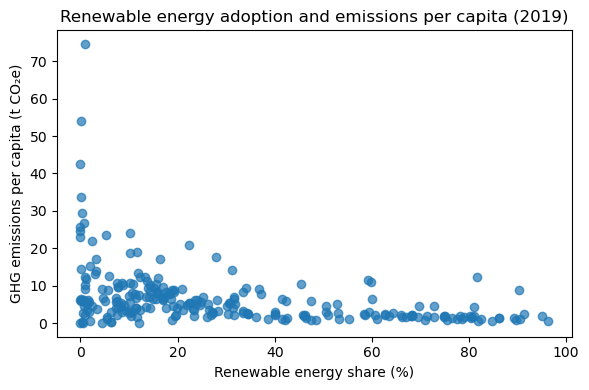

In [70]:
# Scatter plot illustrating the unconditional relationship between
# renewable energy adoption and emissions per capita
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(energy_wide["renewable_share"], energy_wide["ghg_pc"], alpha=0.7)
plt.xlabel("Renewable energy share (%)")
plt.ylabel("GHG emissions per capita (t CO₂e)")
plt.title("Renewable energy adoption and emissions per capita (2019)")
plt.tight_layout()
plt.show()


Figure X illustrates the unconditional association between renewable energy adoption and emissions per capita. While a negative pattern is visible, substantial dispersion remains, motivating the multivariate regression analysis and robustness checks that follow.

In [71]:
energy_wide.columns


Index(['Country Name', 'Country Code', 'gdp_pc', 'population',
       'renewable_share', 'ghg_pc', 'ln_ghg_pc', 'ln_gdp_pc', 'ln_population'],
      dtype='object', name='Series Name')

In [72]:
# Alternative specification excluding population as a robustness check
# This model assesses whether the estimated relationship between
# renewable energy adoption and emissions is sensitive to the inclusion
# of population size as a control variable.

energy_wide["ln_gdp_pc"] = np.log(energy_wide["gdp_pc"])

X_robust = energy_wide[["renewable_share", "ln_gdp_pc"]]
X_robust = sm.add_constant(X_robust)

# Estimate OLS model with reduced set of controls
model_robust = sm.OLS(energy_wide["ln_ghg_pc"], X_robust).fit()

# Format regression results for presentation
robust_table = (
    model_robust
    .summary2()
    .tables[1]
    .round(3)
)

# Rename variables for clarity in the output table
robust_table = robust_table.rename(index={
    "const": "Constant",
    "renewable_share": "Renewable energy share (%)",
    "ln_gdp_pc": "Log GDP per capita"
})

robust_table


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Constant,-2.267,0.544,-4.167,0.000,-3.339,-1.195
Renewable energy share (%),-0.002,0.003,-0.883,0.378,-0.008,0.003
Log GDP per capita,0.422,0.055,7.715,0.000,0.314,0.530


### Robustness Check: Excluding Population

As a robustness check, an alternative specification is estimated excluding population size as a control variable.  
The purpose of this exercise is to assess whether the estimated relationship between renewable energy adoption and greenhouse gas emissions per capita is sensitive to the inclusion of population as a conditioning variable.

The dependent variable remains the logarithm of greenhouse gas emissions per capita, while the model includes renewable energy share and log GDP per capita as explanatory variables.


**Interpretation.**  
The coefficient on renewable energy share remains negative but statistically insignificant, consistent with the baseline specification.  
The magnitude and sign of the GDP per capita coefficient remain stable and statistically significant, indicating that economic development is a robust predictor of emissions intensity.

Overall, the results suggest that the main findings are not driven by the inclusion of population size, supporting the robustness of the baseline model.


## Conclusion

This project analyzed the relationship between renewable energy adoption and greenhouse gas emissions per capita using cross-sectional data for 2019.

The results show that higher income levels are strongly associated with higher emissions per capita, while the relationship between renewable energy share and emissions is negative but not statistically significant. Robustness checks confirm that this finding is not sensitive to model specification.

These results suggest that renewable energy adoption alone may not be sufficient to substantially reduce emissions without complementary policies targeting energy demand, efficiency, and economic structure.

